## Análisis de datos de radiografías de cáncer de mama y modelo clasificador
### Jerónimo Molina Molina
### 2020

#### Antes de proceder con el notebook, te recomiendo que leas el fichero de texto que describe el dataset, seguro que te ayuda a comenzar este análisis con algo de conocimiento sobre éstos datos

### Importación de librerías

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 
import warnings

from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.svm import SVC # Support vector machines classifier
from sklearn.linear_model import LogisticRegression # algoritmo de clasificación.
from sklearn.neighbors import NearestCentroid # algoritmo de knn.
from sklearn.tree import DecisionTreeClassifier # algoritmo de decission trees.
from sklearn.ensemble import ExtraTreesClassifier # un algoritmo de random forest

from sklearn.metrics import confusion_matrix  # para generar la matriz de confusion de los modelos con mejores resultados
from sklearn.metrics import roc_curve, auc  # para generar la curva roc de los modelos con mejores resultados


## Análisis exploratorio de datos

### Análisis preliminar

In [78]:
# Cargamos el dataset
df = pd.read_csv("./data.csv", sep=',')

In [4]:
# Observamos sus tipos de datos. 
# A priori ya se observa que nos van a sobrar el campo 'id' y el campo 'Unnamed: 32' 
# y que tenemos que hacer 'algo' con 'diagnosis' 

df.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [5]:
df.head()

# Puede verse claramente que 'diagnosis' es nuestra variable predictora y tenemos que hacer algo con ella, 
# no puede ser un objeto

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [6]:
df.tail()

# También se observa que los valores de cada columna se encuentran en rangos muy diferentes, lo cual nos lleva
# a pensar en normalizarlos para que al entrenar nuestros modelos clasificadores no cobren algunos más peso que otros.

# Vamos a hacer un describe que nos muestre algo de información sobre las columnas....

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN
568,92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,NaN


In [6]:
df.describe()

# Podemos aprovechar esta descripción para buscar columnas que quizá tengan valores anómalos ... veamos

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


### Eliminación de columnas inservibles

In [79]:
df = df.drop(['Unnamed: 32'], axis=1)
df = df.drop(['id'], axis=1)

In [40]:
df.dtypes

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

In [39]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


### Detección y tratamiento de valores nulos y fuera de rango o atípicos

In [53]:
# En el dataframe no hay valores nulos, por lo que esta parte del análisis y trastamiento no aplica en este caso

df.isnull().values.any()

False

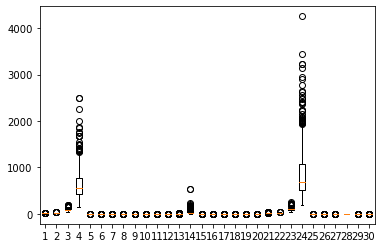

In [28]:
# Para ver mejor la distribución de valores, dibujamos unos diagramas de bigotes, prescindiendo de la priomera columna 'diagnosis'

plt.boxplot(df.iloc[:, 1:].values)
plt.show()

# En el gráfico puede observarse que casi todas las columnas tienen una distribución correcta.
# A continuación vamos a analizar en detalle aquellas que presentan la posibilidad de outliers y decidir al respecto

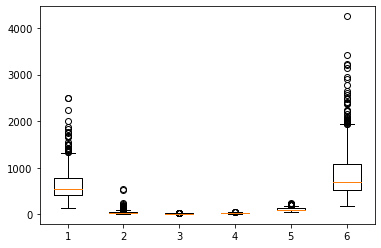

In [37]:
plt.boxplot(df.iloc[:, [4, 14, 21, 22, 23, 24]].values)
plt.show()

# Se puede observar que en estas columnas hay valores que se quedan fuera del rango intercuartílico, por lo que a priori son 
# valores atípicos que deben estudiarse detenidamente.

# Vamos a ello en las celdas siguientes

# Las columnas en las que analizar outliers son:
#   4. area_mean
#  14. area_se
#  21. radius_worst
#  22. texture_worst
#  23. perimeter_worst
#  24. area_worst

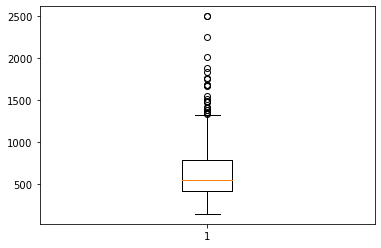

In [31]:
plt.boxplot(df.iloc[:, [4]].values)
plt.show()

In [52]:
df_outl_area_mean = df[df['area_mean'] > 782]
print (df_outl_area_mean['area_mean'])
print ('Total: ',df.shape)
print ('% filas outlier: ', len(df_outl_area_mean)/len(df))

# Podríamos tomar muchas decisiones respecto a todos estos datos, pero por un lado, en este caso, en este dataset, 
# se trata de medias, distancias, etc....datos que en caso de modificarlos podría ser que estuviésemos cambiando datos correctos
# y si eliminamos 144 filas de un total de 569 estamos eliminando la cuarta parte del dataset.... lo que significa que en 4 drop
# hemos eliminado el dataset completo y ya no hay nada que analizar ni modelo que entrenar.

# Conclusión, en este caso, vamos a suponer la veracidad de los datos y asumir éstos valores atípicos como atípicos pero reales.

0      1001.0
1      1326.0
2      1203.0
4      1297.0
6      1040.0
        ...  
563    1347.0
564    1479.0
565    1261.0
566     858.1
567    1265.0
Name: area_mean, Length: 144, dtype: float64
Total:  (569, 31)
% filas outlier:  0.2530755711775044


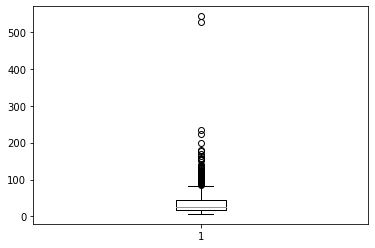

In [32]:
plt.boxplot(df.iloc[:, [14]].values)
plt.show()

In [57]:
print(df['area_se'].describe())
df_outl = df[df['area_se'] > 45]
print (df_outl['area_se'])
print ('Total: ',df.shape)
print ('% filas outlier: ', len(df_outl)/len(df))

count    569.000000
mean      40.337079
std       45.491006
min        6.802000
25%       17.850000
50%       24.530000
75%       45.190000
max      542.200000
Name: area_se, dtype: float64
0      153.40
1       74.08
2       94.03
4       94.44
6       53.91
        ...  
563    118.80
564    158.70
565     99.04
566     48.55
567     86.22
Name: area_se, Length: 143, dtype: float64
Total:  (569, 31)
% filas outlier:  0.2513181019332162


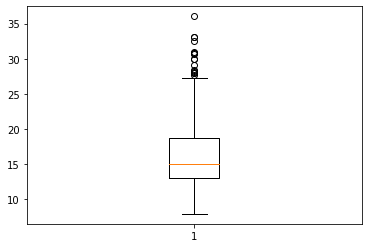

In [33]:
plt.boxplot(df.iloc[:, [21]].values)
plt.show()

In [60]:
print(df['radius_worst'].describe())
df_outl = df[df['radius_worst'] > 19]
print (df_outl['radius_worst'])
print ('Total: ',df.shape)
print ('% filas outlier: ', len(df_outl)/len(df))

count    569.000000
mean      16.269190
std        4.833242
min        7.930000
25%       13.010000
50%       14.970000
75%       18.790000
max       36.040000
Name: radius_worst, dtype: float64
0      25.38
1      24.99
2      23.57
4      22.54
6      22.88
       ...  
535    24.30
563    24.29
564    25.45
565    23.69
567    25.74
Name: radius_worst, Length: 140, dtype: float64
Total:  (569, 31)
% filas outlier:  0.2460456942003515


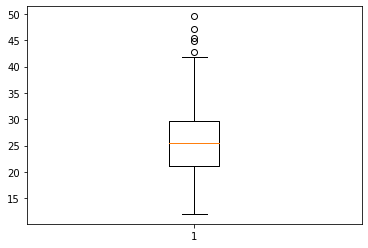

In [34]:
plt.boxplot(df.iloc[:, [22]].values)
plt.show()

In [64]:
print(df['texture_worst'].describe())
df_outl = df[df['texture_worst'] > 30]
print (df_outl['texture_worst'])
print ('Total: ',df.shape)
print ('% filas outlier: ', len(df_outl)/len(df))

count    569.000000
mean      25.677223
std        6.146258
min       12.020000
25%       21.080000
50%       25.410000
75%       29.720000
max       49.540000
Name: texture_worst, dtype: float64
8      30.73
9      40.68
10     33.88
14     32.01
15     37.13
       ...  
562    42.79
565    38.25
566    34.12
567    39.42
568    30.37
Name: texture_worst, Length: 139, dtype: float64
Total:  (569, 31)
% filas outlier:  0.24428822495606328


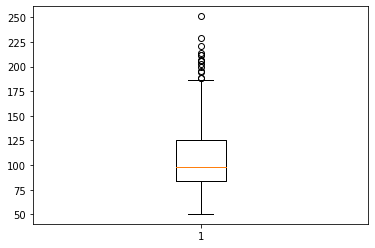

In [35]:
plt.boxplot(df.iloc[:, [23]].values)
plt.show()

In [66]:
print(df['perimeter_worst'].describe())
df_outl = df[df['perimeter_worst'] > 125]
print (df_outl['perimeter_worst'])
print ('Total: ',df.shape)
print ('% filas outlier: ', len(df_outl)/len(df))

count    569.000000
mean     107.261213
std       33.602542
min       50.410000
25%       84.110000
50%       97.660000
75%      125.400000
max      251.200000
Name: perimeter_worst, dtype: float64
0      184.6
1      158.8
2      152.5
4      152.2
6      153.2
       ...  
563    179.1
564    166.1
565    155.0
566    126.7
567    184.6
Name: perimeter_worst, Length: 144, dtype: float64
Total:  (569, 31)
% filas outlier:  0.2530755711775044


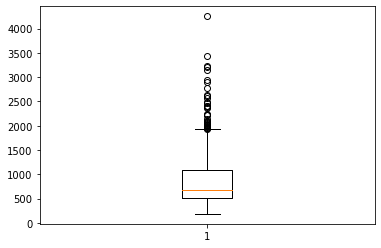

In [36]:
plt.boxplot(df.iloc[:, [24]].values)
plt.show()

In [68]:
print(df['area_worst'].describe())
df_outl = df[df['area_worst'] > 1084]
print (df_outl['area_worst'])
print ('Total: ',df.shape)
print ('% filas outlier: ', len(df_outl)/len(df))

count     569.000000
mean      880.583128
std       569.356993
min       185.200000
25%       515.300000
50%       686.500000
75%      1084.000000
max      4254.000000
Name: area_worst, dtype: float64
0      2019.0
1      1956.0
2      1709.0
4      1575.0
6      1606.0
        ...  
563    1819.0
564    2027.0
565    1731.0
566    1124.0
567    1821.0
Name: area_worst, Length: 142, dtype: float64
Total:  (569, 31)
% filas outlier:  0.24956063268892795


### Tratamiento de la vairable objetivo. Conversión a entero y renombrado de columna

In [80]:
df = pd.get_dummies(df, columns = ["diagnosis"], drop_first = True)
df.rename(columns={'diagnosis_M': 'diagnosis'}, inplace=True)

df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


## Generación de modelos clasificadores

### Preparación de datos para entrenar modelo

In [82]:
X = df.iloc[: , :-1].values
y = df.iloc[:, -1:].values

In [46]:
print(X)
print('========================================')
print(y)

df.describe()

[[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.372583
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,0.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


### Análisis de sesgo en variable objetivo

#### Puede verse que las clases no están balanceadas, a pesar de ello, no parece haber demasiado sesgo

In [83]:
diagnosticos = pd.value_counts(df['diagnosis'])

print('Diagnóstico benigno: ',diagnosticos[0],'(',diagnosticos[0]/(diagnosticos[0]+diagnosticos[1]),'%)')
print('Diagnóstico maligno: ',diagnosticos[1],'(',diagnosticos[1]/(diagnosticos[0]+diagnosticos[1]),'%)')

Diagnóstico benigno:  357 ( 0.6274165202108963 %)
Diagnóstico maligno:  212 ( 0.37258347978910367 %)


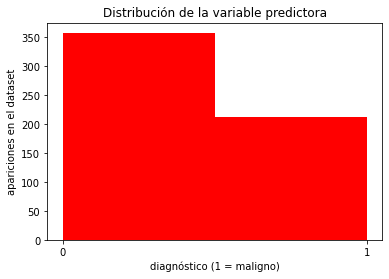

<Figure size 432x288 with 0 Axes>

In [84]:
plt.hist(y,2,facecolor='red')
plt.xticks([0, 1])
plt.xlabel('diagnóstico (1 = maligno)')
plt.ylabel('apariciones en el dataset')
plt.title('Distribución de la variable predictora')
plt.show()
plt.clf()

### Separamos un 20% de los datos para test posterior y escalamos todos los datos para equilibrarlos

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [86]:

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



### Entrenamiento con el clasificador SVM 

In [42]:

model = SVC(kernel='sigmoid', C=1E10)
model.fit(X_train, y_train.ravel())

kf = KFold(n_splits=5, shuffle=True, random_state=123)

scores = cross_val_score(model, X_train, y_train.ravel(), cv=kf, scoring="accuracy")

print("Metricas cross_validation", scores)

print("Media de cross_validation", scores.mean())

preds = model.predict(X_test)

score_pred = metrics.accuracy_score(y_test.ravel(), preds)

print("Metrica en Test", score_pred)


Metricas cross_validation [0.86813187 0.92307692 0.94505495 0.94505495 0.95604396]
Media de cross_validation 0.9274725274725275
Metrica en Test 0.956140350877193


### Entrenamiento con el clasificador regresión logística

In [52]:
model = LogisticRegression(penalty='l2', C=1E10)
model.fit(X_train, y_train.ravel())

kf = KFold(n_splits=5, shuffle=True, random_state=123)

scores = cross_val_score(model, X_train, y_train.ravel(), cv=kf, scoring="accuracy")

print("Metricas cross_validation", scores)

print("Media de cross_validation", scores.mean())

preds = model.predict(X_test)

score_pred = metrics.accuracy_score(y_test.ravel(), preds)

print("Metrica en Test", score_pred)

Metricas cross_validation [0.91208791 0.94505495 0.96703297 0.96703297 0.95604396]
Media de cross_validation 0.9494505494505494
Metrica en Test 0.9385964912280702


### Entrenamiento con el clasificador knn

In [87]:
model_knn = NearestCentroid(metric='manhattan')
model_knn.fit(X_train, y_train.ravel())

kf = KFold(n_splits=5, shuffle=True, random_state=123)

scores = cross_val_score(model_knn, X_train, y_train.ravel(), cv=kf, scoring="accuracy")

print("Metricas cross_validation", scores)

print("Media de cross_validation", scores.mean())

preds_knn = model_knn.predict(X_test)

score_pred = metrics.accuracy_score(y_test.ravel(), preds_knn)

print("Metrica en Test", score_pred)

Metricas cross_validation [0.91208791 0.93406593 0.9010989  0.92307692 0.97802198]
Media de cross_validation 0.9296703296703297
Metrica en Test 0.9736842105263158


### Entrenamiento con el clasificador árboles de decisión

In [80]:
model = DecisionTreeClassifier(criterion='entropy', min_samples_split=2, max_features='auto')
model.fit(X_train, y_train.ravel())

kf = KFold(n_splits=5, shuffle=True, random_state=123)

scores = cross_val_score(model, X_train, y_train.ravel(), cv=kf, scoring="accuracy")

print("Metricas cross_validation", scores)

print("Media de cross_validation", scores.mean())

preds = model.predict(X_test)

score_pred = metrics.accuracy_score(y_test.ravel(), preds)

print("Metrica en Test", score_pred)

Metricas cross_validation [0.9010989  0.87912088 0.89010989 0.9010989  0.96703297]
Media de cross_validation 0.9076923076923077
Metrica en Test 0.956140350877193


### Entrenamiento con el clasificador random forest

In [88]:
model_rf = ExtraTreesClassifier(n_estimators=100, criterion='entropy')
model_rf.fit(X_train, y_train.ravel())

kf = KFold(n_splits=5, shuffle=True, random_state=123)

scores = cross_val_score(model_rf, X_train, y_train.ravel(), cv=kf, scoring="accuracy")

print("Metricas cross_validation", scores)

print("Media de cross_validation", scores.mean())

preds_rf = model_rf.predict(X_test)

score_pred = metrics.accuracy_score(y_test.ravel(), preds_rf)

print("Metrica en Test", score_pred)

Metricas cross_validation [0.95604396 0.98901099 0.96703297 0.94505495 0.98901099]
Media de cross_validation 0.9692307692307693
Metrica en Test 0.9736842105263158


### Generación de matriz de confusión y de área bajo curva ROC para knn y random forest

#### Matriz de confusion y curva ROC para knn

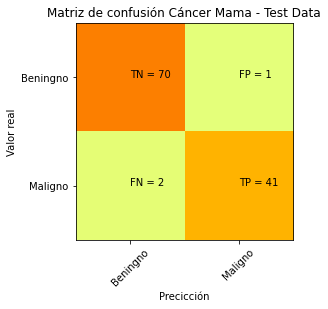

In [93]:

cm = confusion_matrix(y_test, preds_knn)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Benigno','Maligno']
plt.title('Matriz de confusión Cáncer Mama - Test Data')
plt.ylabel('Valor real')
plt.xlabel('Precicción')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


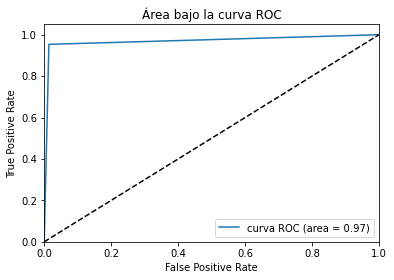

In [111]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds_knn)
roc_auc = metrics.auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, label='curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Área bajo la curva ROC')
plt.legend(loc="lower right")
plt.show()

#### Matriz de confusion y curva ROC para random forest

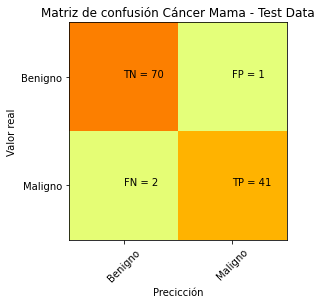

In [104]:
cm = confusion_matrix(y_test, preds_rf)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Benigno','Maligno']
plt.title('Matriz de confusión Cáncer Mama - Test Data')
plt.ylabel('Valor real')
plt.xlabel('Precicción')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

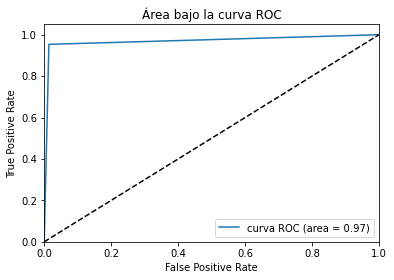

In [112]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds_rf)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Área bajo la curva ROC')
plt.legend(loc="lower right")
plt.show()